In [2]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

'apt'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [4]:
%pip install fonts-nanum -y

Note: you may need to restart the kernel to use updated packages.



Usage:   
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] [-e] <vcs project url> ...
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] [-e] <local project path> ...
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] <archive url/path> ...

no such option: -y


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [15]:
import os
import shutil



directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            # print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            # print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

In [16]:
query = '0'
dataset_split(query, 210)
query = '1'
dataset_split(query, 210)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

c:\prj\team3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(2022)
torch.cuda.manual_seed(2022)

In [3]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

# shuffle : set to True to have the data reshuffled at every epoch (이거 True 설정해도 결과값이 같게 나오네 완전 랜덤으로 섞는건 아닌듯)
# num_workers : how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.
# 보통의 일반적인 환경에서 오픈소스로 풀려있는 모델을 학습시킬때는 코어 개수의 절반정도 수치면 무난하게 시스템 리소스를 사용하며 학습이 가능했습니다
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 2004
테스트 데이터셋 크기: 3038
클래스: ['0', '1']


tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1])
(3, 906, 1810)
===input==> (906, 1810, 3)


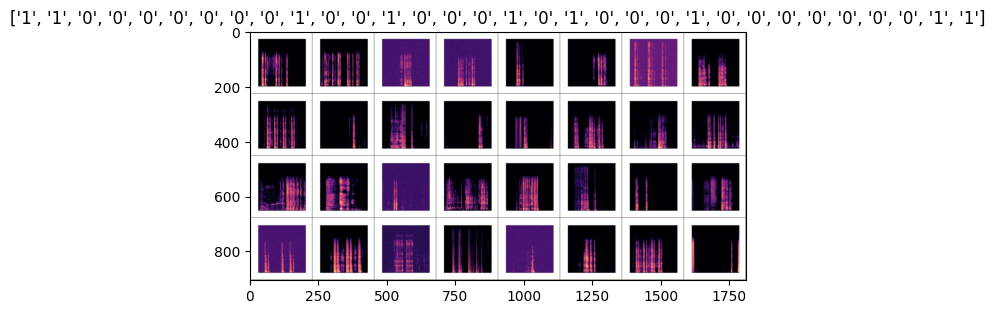

In [4]:
import matplotlib.pyplot as plt

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    print(input.numpy().shape)

    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력

    print('===input==>',input.shape)
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
print(classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
# 이미 학습된 resnet34 신경망을 불러온다
model = models.resnet34(pretrained=True)
print(model)
#for name,module in model.named_parameters():
#    module.requires_grad = False
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
for name,module in model.named_parameters():
    print( module.requires_grad )
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

#stochastic gradint descent : 확률적 경사하강법
#미니배치를 사용하여 다소 부정확할수는 있지만 계산 속도가 빠르다.


c:\prj\team3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\prj\team3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# num_epochs = 200
# model.train()
# start_time = time.time()
# writer = SummaryWriter()

# # 전체 반복(epoch) 수 만큼 반복하며
# for epoch in range(num_epochs):
#     running_loss = 0.
#     running_corrects = 0

#     # 배치 단위로 학습 데이터 불러오기
#     for inputs, labels in train_dataloader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # 모델에 입력(forward)하고 결과 계산
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)

#     epoch_loss = running_loss / len(train_datasets)
#     epoch_acc = running_corrects / len(train_datasets) * 100.
#     writer.add_scalar("Loss/train", epoch_loss, epoch)
#     writer.add_scalar("acc/train", epoch_acc, epoch)
#     writer.add_scalar("sum/train", epoch_loss, epoch)
#     # writer.add_scalar("sum/train", epoch_acc/100, epoch)

#     # 학습 과정 중에 결과 출력
#     print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

# writer.flush()
# writer.close()

#0 Loss: 5.4785 Acc: 53.5429% Time: 7.7399s
#1 Loss: 3.8845 Acc: 54.5409% Time: 15.4265s
#2 Loss: 5.6512 Acc: 54.9900% Time: 23.1467s
#3 Loss: 5.3920 Acc: 54.2914% Time: 30.7902s
#4 Loss: 4.8860 Acc: 54.9401% Time: 38.4101s
#5 Loss: 4.4315 Acc: 56.0878% Time: 46.0553s
#6 Loss: 5.0751 Acc: 55.3892% Time: 53.6808s
#7 Loss: 5.1890 Acc: 54.6407% Time: 61.2118s
#8 Loss: 4.8743 Acc: 55.1397% Time: 68.8264s
#9 Loss: 4.2732 Acc: 56.4371% Time: 76.4265s
#10 Loss: 4.4926 Acc: 57.9341% Time: 84.0219s
#11 Loss: 4.8677 Acc: 55.7884% Time: 91.5816s
#12 Loss: 4.4856 Acc: 55.7385% Time: 99.1684s
#13 Loss: 4.5875 Acc: 56.3872% Time: 106.7769s
#14 Loss: 5.6784 Acc: 56.9860% Time: 114.3750s
#15 Loss: 4.4142 Acc: 56.4870% Time: 122.0486s
#16 Loss: 5.0942 Acc: 56.8862% Time: 129.6353s
#17 Loss: 4.9072 Acc: 57.7844% Time: 137.2828s
#18 Loss: 5.5248 Acc: 57.9840% Time: 144.8415s
#19 Loss: 4.8779 Acc: 55.8882% Time: 152.3683s
#20 Loss: 4.5187 Acc: 57.7844% Time: 159.9798s
#21 Loss: 4.8342 Acc: 57.6846% Time: 

In [6]:
num_epochs = 200
# model.train()
start_time = time.time()
writer = SummaryWriter()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    model.train()
    criterion.train()
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("Acc/train", epoch_acc, epoch)
    writer.add_scalars("Loss_Acc/train", {'epoch_loss_train': epoch_loss, 'epoch_acc_train': epoch_acc/100}, epoch)
    writer.add_scalar("Loss/sum", epoch_loss, epoch)
    writer.add_scalar("Acc/sum", epoch_acc, epoch)
    writer.add_scalars("Loss_Acc/sum", {'epoch_loss_train': epoch_loss, 'epoch_acc_train': epoch_acc/100}, epoch)

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    #save
    torch.save(model.state_dict(), f'C:/team3/resnet/models/#17 resnet_models/resnet_dict{epoch}.pth')

# writer.flush()
writer.close()

#0 Loss: 0.7170 Acc: 51.0479% Time: 12.2510s
#1 Loss: 0.7022 Acc: 52.4451% Time: 19.2092s
#2 Loss: 0.6993 Acc: 53.2435% Time: 26.3166s
#3 Loss: 0.6927 Acc: 53.9421% Time: 33.6945s
#4 Loss: 0.6872 Acc: 54.7904% Time: 40.6853s
#5 Loss: 0.6834 Acc: 56.1876% Time: 47.8036s
#6 Loss: 0.6808 Acc: 56.5369% Time: 54.6457s
#7 Loss: 0.6749 Acc: 56.8363% Time: 61.5136s
#8 Loss: 0.6728 Acc: 58.2335% Time: 68.6076s
#9 Loss: 0.6715 Acc: 57.2854% Time: 75.6116s
#10 Loss: 0.6669 Acc: 58.9820% Time: 82.5004s
#11 Loss: 0.6640 Acc: 59.3313% Time: 89.4345s
#12 Loss: 0.6591 Acc: 59.3812% Time: 96.2332s
#13 Loss: 0.6536 Acc: 59.9301% Time: 103.0238s
#14 Loss: 0.6580 Acc: 61.2275% Time: 109.8576s
#15 Loss: 0.6518 Acc: 61.0279% Time: 116.6250s
#16 Loss: 0.6571 Acc: 60.3792% Time: 123.3284s
#17 Loss: 0.6534 Acc: 61.9760% Time: 130.1007s
#18 Loss: 0.6492 Acc: 62.7245% Time: 136.8233s
#19 Loss: 0.6512 Acc: 61.6766% Time: 143.7048s
#20 Loss: 0.6443 Acc: 63.7226% Time: 150.5501s
#21 Loss: 0.6415 Acc: 63.0240% Time:

In [7]:
import os

path = "C:/team3/resnet/models/#17 resnet_models"
file_list = os.listdir(path)
writer1 = SummaryWriter()

for epoch, file in enumerate(file_list):
    model = models.resnet34(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)

    model.load_state_dict(torch.load(path + "/" + file))
    model.eval()
    model.to("cuda")

    with torch.no_grad():
        test_loss = 0.
        test_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
            # print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
            # imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss1 = test_loss / len(test_datasets)
    epoch_acc1 = test_corrects / len(test_datasets) * 100.
    print('#{} [Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss1, epoch_acc1, time.time() - start_time))

    writer1.add_scalar("Loss/test", epoch_loss1, epoch)
    writer1.add_scalar("Acc/test", epoch_acc1, epoch)
    writer1.add_scalars("Loss_Acc/test", {'epoch_loss_test': epoch_loss1, 'epoch_acc_test': epoch_acc1/100}, epoch)
    writer1.add_scalar("Loss/sum", epoch_loss1, epoch)
    writer1.add_scalar("Acc/sum", epoch_acc1, epoch)
    writer1.add_scalars("Loss_Acc/sum", {'epoch_loss_test': epoch_loss1, 'epoch_acc_test': epoch_acc1/100}, epoch)

    # writer1.add_scalars("Loss/sum", {'epoch_loss_train': epoch_loss, 'epoch_loss_test': epoch_loss1}, epoch)
    # writer1.add_scalars("Acc/sum", {'epoch_acc_train': epoch_acc/100, 'epoch_acc_test': epoch_acc1/100}, epoch)
    # writer1.add_scalars("Loss_Acc/sum", {'epoch_loss_train': epoch_loss, 'epoch_loss_test': epoch_loss1, 'epoch_acc_train': epoch_acc/100, 'epoch_acc_test': epoch_acc1/100}, epoch)

writer1.close()

c:\prj\team3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\prj\team3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#0 [Test Phase] Loss: 0.7478 Acc: 45.6550% Time: 1589.6481s
#1 [Test Phase] Loss: 0.7723 Acc: 43.0546% Time: 1598.4317s
#2 [Test Phase] Loss: 0.6724 Acc: 57.2745% Time: 1607.0761s
#3 [Test Phase] Loss: 0.6644 Acc: 60.4674% Time: 1615.8905s
#4 [Test Phase] Loss: 0.8034 Acc: 47.3996% Time: 1624.5038s
#5 [Test Phase] Loss: 0.5981 Acc: 67.8078% Time: 1633.3815s
#6 [Test Phase] Loss: 0.6333 Acc: 64.0882% Time: 1642.2179s
#7 [Test Phase] Loss: 0.7227 Acc: 54.2791% Time: 1650.7619s
#8 [Test Phase] Loss: 0.7452 Acc: 52.7321% Time: 1659.5939s
#9 [Test Phase] Loss: 0.6690 Acc: 60.0724% Time: 1668.2938s
#10 [Test Phase] Loss: 0.5937 Acc: 68.5319% Time: 1677.2962s
#11 [Test Phase] Loss: 0.7355 Acc: 53.3904% Time: 1686.1885s
#12 [Test Phase] Loss: 0.7544 Acc: 51.7116% Time: 1694.9512s
#13 [Test Phase] Loss: 0.7338 Acc: 48.3871% Time: 1703.8505s
#14 [Test Phase] Loss: 0.6611 Acc: 61.0599% Time: 1712.7735s
#15 [Test Phase] Loss: 0.6375 Acc: 63.3311% Time: 1721.5304s
#16 [Test Phase] Loss: 0.6759 Acc:

In [ ]:
#0 Loss: 0.8026 Acc: 50.9524% Time: 39.0565s
#0 Loss: 0.8026 Acc: 50.9524% Time: 37.5618s
#0 Loss: 0.8026 Acc: 50.9524% Time: 32.1134s

In [14]:
#모델 저장

torch.save(model.state_dict(),'resnet_dict.pth')
# torch.save(model,'model.pth')
torch.save(model,'resnet.h5')

In [18]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model.load_state_dict(torch.load('#2 resnet_dict.pth'))
model.eval()
model.to("cuda")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# model.eval()
start_time = time.time()
writer = SummaryWriter()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))
    
    # writer.add_scalar("Loss/train", epoch_loss, epoch)
    # writer.add_scalar("acc/train", epoch_acc, epoch)
    # writer.add_scalar("sum/train", epoch_loss, epoch)
    writer.add_scalar("sum/train", epoch_acc/100, epoch)

writer.flush()
writer.close()

[예측 결과: 1] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 1)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0]

In [ ]:

[Test Phase] Loss: 1.4326 Acc: 10.5003% Time: 209.7178s
[Test Phase] Loss: 1.4326 Acc: 10.5003% Time: 215.8944s

In [ ]:
from PIL import Image


image = Image.open('test_img.jpg')
image = transforms_test(image).unsqueeze(0).to(device)
print(image.shape)
with torch.no_grad():
    outputs = model(image)
    
    _, preds = torch.max(outputs, 1)
    print(outputs)
    print(class_names[preds[0]])
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

### 저장한 모델 가져와서 쓰기

In [ ]:
from google.colab import files
files.download("resnet_dict.pth")

In [ ]:
files.download("resnet.pth")

In [10]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model.load_state_dict(torch.load('#2 resnet_dict.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from PIL import Image
model = model.to(device)
image = Image.open('test.jpg')
image = transforms_test(image).unsqueeze(0).to(device)
print(image.shape)
with torch.no_grad():
    outputs = model(image)
    
    _, preds = torch.max(outputs, 1)
    print(outputs)
    print(class_names[preds[0]])
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])